# 2) Component Selection and Data Pipeline Implementation _code_	**10 Marks**

At first , I am importing all the necesssary python libraries required for my task . I am using :

Pandas - It is used for handling data manipulations, because of pandas library cleaning data , transformation of data , filtering data suitable for my analysis became easier.

Numpy - I am using numpy library for carrying out numerical operations as it makes this task efficiently for large datasets.   

matplotlib , seaborn - These libraries help in Visual analysis and from these libraries graphical plots and visulaizations are created. inline code tells compiler to show matplotlib plots inside jupyter notebook.   

pyspark libraries - I am using pyspark for this analysis and due to that i am using packages inside pyspark library to create a sparkcontext, session for analysis and have imported sql functions to filter out and select data which is most suitable for my type of analysis.    

After all these imports a sparkSession is created which is the entry point to the analysis as i am using pyspark to analyze this large data and Pyspark makes analysis of huge data practically possible .













In [ ]:
#Importing all the Required Libraries for whole analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
!pip install squarify
import squarify
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import isnan, when, count, col, to_date
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import scipy.stats as stats
!pip install findspark
import findspark
findspark.init()

from pyspark.sql import SparkSession

In [ ]:
# Initializing SparkSession and Creating it
spark = SparkSession.builder.appName("UKCrimeAnalysisCloudComputing") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

In [ ]:
spark

**Dataset**

1.  Reading UK Crime Data

The given dataset1 for analysis is a 12.6 gb data where information of crimes occured in United Kingdom is documneted and has many columns. I am using another instance of same dataset which is provided and is of 2.32 gb of size.

I have uploaded the given data in a azure blob storage container and given it public access permissions. From there i am reading data into my notebook.   


I have first specified a schema named as myschema and in this I have mentioned how do i need to import this data i.e. in what format data should be read into sparkdataframe is specified.Then here url has link url for UK crimedata, url1 has the link for population data from azure blob storage.   

I have read the UK crime data into spark dataframe df by using the schema defined earlier and dispayed the UK crime data.

In [ ]:

# Defining a schema
myschema = StructType([
    StructField("Crime ID", DoubleType(), True),
    StructField("Month", StringType(), True),
    StructField("Reported by", StringType(), True),
    StructField("Falls within", StringType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Location", StringType(), True),
    StructField("LSOA code", StringType(), True),
    StructField("LSOA name", StringType(), True),
    StructField("Crime type", StringType(), True),
    StructField("Last outcome category", StringType(), True),
    StructField("Context", StringType(), True)
])



# url is link for crimedata, url1 is the link for population data from azure blob storage
url = r'https://crimedataa2.blob.core.windows.net/crime/all_crimes21_hdr.txt.gz'
url1 = r'https://crimedataa2.blob.core.windows.net/location/LSOA_pop_v2.csv'

#reading crime data as df
#using sparkcontext i am distributing this large file across all nodes in sparkcluster and then reading the data into df
spark.sparkContext.addFile(url)
df = spark.read.option("header", "true").option("delimiter", ",").schema(myschema).csv(SparkFiles.get("all_crimes21_hdr.txt.gz"))


# Converting the "Month" column to date format
df = df.withColumn("Month", to_date(df["Month"], "yyyy-MM"))

# Showing the DataFrame
df.show(truncate=False)


+--------+----------+------------------------------+------------------------------+---------+---------+----------------------------+---------+---------------------------------+---------------------+---------------------+-------+
|Crime ID|Month     |Reported by                   |Falls within                  |Longitude|Latitude |Location                    |LSOA code|LSOA name                        |Crime type           |Last outcome category|Context|
+--------+----------+------------------------------+------------------------------+---------+---------+----------------------------+---------+---------------------------------+---------------------+---------------------+-------+
|NULL    |2010-12-01|Avon and Somerset Constabulary|Avon and Somerset Constabulary|-0.8056  |51.819143|On or near Norfolk Terrace  |E01017662|Aylesbury Vale 015C              |Other crime          |NULL                 |NULL   |
|NULL    |2010-12-01|Avon and Somerset Constabulary|Avon and Somerset Constabulary|-

2. Reading location data

I have read the UK Location data from the azure blob storage, assigned to url1 and read as spark dataframe df1 and displayed it.

In [ ]:
# reading location data as df1
spark.sparkContext.addFile(url1)
df1 = spark.read.csv(SparkFiles.get("LSOA_pop_v2.csv"), header=True, sep=",", inferSchema=True)
df1.show()

+----+---------------+--------------+-----------+----------------------------------------------+--------------------------------+----------------------------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+
|date|      geography|geography code|Rural Urban|Variable: All usual residents; measures: Value|Variable: Males; measures: Value|Variable: Females; measures: Value|Variable: Lives in a household; measures: Value|Variable: Lives in a communal establishment; measures: Value|Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value|Variable: Area (Hectares); measures: Value|Variable: Density (number of persons per hectare); measures: Value|
+----+------------

**Exploring the Data Loaded**

1. Exploring UK Crime Data

By the displayed Crime data above we can Observe there are 12 Attributes in total here and this is a very large dataset which can be seen by looking at total number of entries which is **65078250**. Attributes which can be seen are:

Crime ID - ID given to Crime while registering Complaint.     
Month - Date on which crime occured.  
Reported by - Information of Police station that has Recorded crime.                  
Falls within - Information of Jurisdiction where crime occurred.                  
Longitude - Crime Location Longitude.       
Latitude - Crime Location Latitude.   
Location - Information of place where crime occurred.                  
LSOA code -       
LSOA name -                       
Crime type -           
Last outcome category -
Context -   


Then I have checked for Missing data Values and we can see that missingness is present in data .    

We can see that there are 16 different kinds of crime presnt in the whole data and count for each is also listed.

In [ ]:
print("Total number of entries in UKCrime data is ",df.count())

Total number of entries in UKCrime data is  65078250


Missingness Check of UK Crime Data

In [ ]:
print(" Missing data presense check in UK Crime Data  " )
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

 Missing data presense check in UK Crime Data  
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+
|Crime ID|Month|Reported by|Falls within|Longitude|Latitude|Location|LSOA code|LSOA name|Crime type|Last outcome category| Context|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+
|65078250|    0|          0|           0|   957447|  957447|       0|  2528265|  2528265|         0|             26418132|64955845|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+



Check How many different kinds of crimes are present in total in the dataset and their counts.

In [ ]:
df.registerTempTable("crime_table")
types_crime = spark.sql("SELECT `Crime type`, COUNT(*) AS cnt FROM crime_table WHERE `Crime type` IS NOT NULL GROUP BY `Crime type` ORDER BY cnt")

types_crime.show(truncate = False)  # Display the results

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+----------------------------+--------+
|Crime type                  |cnt     |
+----------------------------+--------+
|Public disorder and weapons |242145  |
|Possession of weapons       |283189  |
|Robbery                     |696008  |
|Theft from the person       |714621  |
|Bicycle theft               |735689  |
|Violent crime               |1673219 |
|Drugs                       |1682486 |
|Public order                |2564695 |
|Other crime                 |2565111 |
|Shoplifting                 |3227557 |
|Vehicle crime               |4170769 |
|Burglary                    |4350252 |
|Other theft                 |5206259 |
|Criminal damage and arson   |5343182 |
|Violence and sexual offences|11411540|
|Anti-social behaviour       |20211528|
+----------------------------+--------+



In [ ]:
types_crime.select("Crime type").count()

16

2. Exploring the Location Data

By Looking at the Location data displayed above we can observe this data contains information on UK Locations and geography codes and their respective population counts and Area of that location.       

Total entries in this location data is 34753 and there no Missingness in data.

In [ ]:
print("Total number of entries in Location data is ",df1.count())

Total number of entries in Location data is  34753


In [ ]:
print(" Missing data presense check in Location Data  " )
df1.select([count(when(col(c).isNull(), c)).alias(c) for c in df1.columns]).show()

 Missing data presense check in Location Data  
+----+---------+--------------+-----------+----------------------------------------------+--------------------------------+----------------------------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+
|date|geography|geography code|Rural Urban|Variable: All usual residents; measures: Value|Variable: Males; measures: Value|Variable: Females; measures: Value|Variable: Lives in a household; measures: Value|Variable: Lives in a communal establishment; measures: Value|Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value|Variable: Area (Hectares); measures: Value|Variable: Density (number of persons per hectare);

# 3) Data Extraction and Filtering , 10 Marks



1. Filtering data for Violent Crime in UK Analysis

Here I am Filtering and extracting the data , such that Violent Crime Analysis task becomes easier. I am considering the Crime Types "Violent crime", "Violence and sexual offences","Robbery" as a category which represents violent crime because these are considered as Violent crime in UK.    

I have loaded the filtered data into violent_df spark dataframe and we can see that in total **13780767** violent crime entries are present. we can see the distribution and there is missingness in the data . Now i need to do Timeseries analysis to find if Violent crime is increasing decreasing or stable in UK for that i have considered just month and Crime type columns then Created a Modified version of it in Pandas dataframe which has Total violent crime counts across all the months and converted month attribute to hold datetime values and stored as PdTimeseriesdf and then in another Pandas dataframe PdTimeseriesdfIndex which has Month as Index .

In [ ]:
# filtering data of violent crime
violent_df = df.filter(df["Crime type"].isin("Violent crime", "Violence and sexual offences","Robbery"))
violent_df.show()

+--------+----------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+-------------+---------------------+-------+
|Crime ID|     Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|   Crime type|Last outcome category|Context|
+--------+----------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+-------------+---------------------+-------+
|    NULL|2010-12-01|Avon and Somerset...|Avon and Somerset...|-2.511019|51.405366|On or near Oak Tr...|E01014402|Bath and North Ea...|      Robbery|                 NULL|   NULL|
|    NULL|2010-12-01|Avon and Somerset...|Avon and Somerset...|-2.509773|51.405767|On or near Cedar ...|E01014402|Bath and North Ea...|Violent crime|                 NULL|   NULL|
|    NULL|2010-12-01|Avon and Somerset...|Avon and Somerset...|-2.497371|51.412906|On or near Temple

In [ ]:
print("Total count of Violent crime as per Filtered  data :" ,violent_df.count())

Total count of Violent crime as per Filtered  data : 13780767


In [ ]:
# Cross Checking the filtered data by comparing it to original data counts
violent_crimes = types_crime.filter(types_crime["Crime type"].isin("Violent crime", "Violence and sexual offences", "Robbery"))

# Calculate the selected sum of 'cnt' from original data
total_violent_crimes = violent_crimes.agg({"cnt": "sum"}).collect()[0][0]

print(f"Total count of Violent crime as per Original data : {total_violent_crimes}")

Total count of Violent crime as per Original data : 13780767


In [ ]:
print("Data Distribution of Violent Crime in Uk")
violent_crimes.show()

Data Distribution of Violent Crime in Uk
+--------------------+--------+
|          Crime type|     cnt|
+--------------------+--------+
|             Robbery|  696008|
|       Violent crime| 1673219|
|Violence and sexu...|11411540|
+--------------------+--------+



In [ ]:
print(" Missing data presense check in UK Violent Crime Data  " )
violent_df.select([count(when(col(c).isNull(), c)).alias(c) for c in violent_df.columns]).show()

 Missing data presense check in UK Violent Crime Data  
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+
|Crime ID|Month|Reported by|Falls within|Longitude|Latitude|Location|LSOA code|LSOA name|Crime type|Last outcome category| Context|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+
|13780767|    0|          0|           0|   306980|  306980|       0|   663525|   663525|         0|              1403813|13765781|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+



From Violent Crimes filtering columns to do Timeseries Analysis

In [ ]:
timeseries_df = violent_df.select("Month" ,"Crime type")
timeseries_df.show()

+----------+-------------+
|     Month|   Crime type|
+----------+-------------+
|2010-12-01|      Robbery|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
+----------+-------------+
only showing top 20 rows



Group the UK Violent Crime data to show counts of total Violent crime across each months and convert the spark data to Pandas

In [ ]:
# Group by month and count crimes before converting to Pandas
PdTimeseriesdf = timeseries_df.groupBy("Month").agg(F.count("Crime type").alias("Crime Count")).toPandas()
PdTimeseriesdf.Month = PdTimeseriesdf.Month.astype('datetime64[ns]')
PdTimeseriesdf = PdTimeseriesdf.sort_values(by='Month')
PdTimeseriesdf

,Month,Crime Count
4,2010-12-01,63311
21,2011-01-01,66490
58,2011-02-01,63171
22,2011-03-01,68884
76,2011-04-01,70574
...,...,...
45,2021-01-01,145202
31,2021-02-01,138735
70,2021-03-01,170905
106,2021-04-01,157594


Converting the Month column data as a Index data

In [ ]:
PdTimeseriesdfIndex = PdTimeseriesdf
PdTimeseriesdfIndex.set_index('Month',inplace=True)
PdTimeseriesdfIndex

,Crime Count
Month,
2010-12-01,63311
2011-01-01,66490
2011-02-01,63171
2011-03-01,68884
2011-04-01,70574
...,...
2021-01-01,145202
2021-02-01,138735
2021-03-01,170905


2. Filtering data for Firearm Crime Incidents Analysis

Similarly as above here in this section i am filtering and extracting firearm incidents data based on Crime type "Possession of weapons" and where "Last outcome category" has  "Offender sent to prison" into spark dataframe firearm_incidents.    

I checked for missingness and missing data is present but here i am doing analysis based on LSOA name so dropping the entries where LSOA name is NULL. Then i have tranformed this data to have Firearm incidents across locations in one dataframe then converted it to pandas and stored in pandas dataframe. Then I have dropped postcodes to generalize data and got a more generalized view which shows total firearm incidents count across cities in firearm_crime_counts_by_location dataframe.

In [ ]:
from os import truncate
# Filtering for firearm incidents on basis of(Possession of weapons with outcome "Offender sent to prison")
firearm_incidents = df.filter((col("Crime type") == "Possession of weapons") & (col("Last outcome category") == "Offender sent to prison"))
firearm_incidents.show(truncate = False)


+--------+----------+------------------------------+------------------------------+---------+---------+---------------------------------+---------+---------------------+---------------------+-----------------------+-------+
|Crime ID|Month     |Reported by                   |Falls within                  |Longitude|Latitude |Location                         |LSOA code|LSOA name            |Crime type           |Last outcome category  |Context|
+--------+----------+------------------------------+------------------------------+---------+---------+---------------------------------+---------+---------------------+---------------------+-----------------------+-------+
|NULL    |2013-05-01|Avon and Somerset Constabulary|Avon and Somerset Constabulary|-2.595297|51.490694|On or near Wellington Hill West  |E01014636|Bristol 004D         |Possession of weapons|Offender sent to prison|NULL   |
|NULL    |2013-05-01|Avon and Somerset Constabulary|Avon and Somerset Constabulary|-2.51668 |51.476465|O

In [ ]:
print(" Missing data presense check in Firearm Crimes Data  " )
firearm_incidents.select([count(when(col(c).isNull(), c)).alias(c) for c in firearm_incidents.columns]).show()
print("Total no of Firearm Incidents Recorded",firearm_incidents.count())

 Missing data presense check in Firearm Crimes Data  
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+
|Crime ID|Month|Reported by|Falls within|Longitude|Latitude|Location|LSOA code|LSOA name|Crime type|Last outcome category|Context|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+
|   10416|    0|          0|           0|      294|     294|       0|      294|      294|         0|                    0|  10416|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+

Total no of Firearm Incidents Recorded 10416


Dropping Null Valued Entries in Firearm Crime Data

In [ ]:
# Removing rows where "LSOA name" are NULL
firearm_incidents = firearm_incidents.dropna(subset=["LSOA name"])

print(" Missing data presense check in Firearm Crimes Data After Removing null valued entries in LSOA name " )
firearm_incidents.select([count(when(col(c).isNull(), c)).alias(c) for c in firearm_incidents.columns]).show()
print("After Removing null valued entries Total no of Firearm Incidents Recorded Present",firearm_incidents.count())

 Missing data presense check in Firearm Crimes Data After Removing null valued entries in LSOA name 
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+
|Crime ID|Month|Reported by|Falls within|Longitude|Latitude|Location|LSOA code|LSOA name|Crime type|Last outcome category|Context|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+
|   10122|    0|          0|           0|        0|       0|       0|        0|        0|         0|                    0|  10122|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+

After Removing null valued entries Total no of Firearm Incidents Recorded Present 10122


In [ ]:
# Group by LSOA name and count incidents
firearm_incidents_by_lsoa = firearm_incidents.groupBy("LSOA name").agg(count("Crime type").alias("Firearm Incidents"))
firearm_incidents_by_lsoa = firearm_incidents_by_lsoa.toPandas()
firearm_incidents_by_lsoa

,LSOA name,Firearm Incidents
0,Sheffield 074C,17
1,Bradford 039G,17
2,Liverpool 044D,1
3,Amber Valley 010C,2
4,Blackpool 010D,4
...,...,...
6174,Lincoln 006C,1
6175,Telford and Wrekin 014F,1
6176,West Berkshire 011D,1
6177,Westminster 010A,1


In [ ]:
firearm_incidents_by_lsoa1 = firearm_incidents_by_lsoa.copy()
firearm_incidents_by_lsoa1['LSOA name'] = firearm_incidents_by_lsoa1['LSOA name'].fillna('').astype(str)
firearm_incidents_by_lsoa1['LSOA name'] = firearm_incidents_by_lsoa1['LSOA name'].str.split().str[:-1].apply(' '.join)
firearm_incidents_by_lsoa1


,LSOA name,Firearm Incidents
0,Sheffield,17
1,Bradford,17
2,Liverpool,1
3,Amber Valley,2
4,Blackpool,4
...,...,...
6174,Lincoln,1
6175,Telford and Wrekin,1
6176,West Berkshire,1
6177,Westminster,1


In [ ]:
firearm_crime_counts_by_location = firearm_incidents_by_lsoa1.groupby('LSOA name')['Firearm Incidents'].sum().sort_values(ascending=False)
firearm_crime_counts_by_location

,Firearm Incidents
LSOA name,
Birmingham,235
Leeds,203
Liverpool,170
Manchester,157
Sheffield,156
...,...
Runnymede,1
Harborough,1
Lewes,1


3. Location Data Filtering such that it aids our analysis based on Location

Here I am filtering and transforming location data , first i have converted data into pandas then I have removed the postcodes from geography entries. Then here i have taken generalized cities by groupby  with total numbere of residents present in those cities into location_df dataframe.  

In [ ]:
df1=df1.toPandas()
df1

,date,geography,geography code,Rural Urban,Variable: All usual residents; measures: Value,Variable: Males; measures: Value,Variable: Females; measures: Value,Variable: Lives in a household; measures: Value,Variable: Lives in a communal establishment; measures: Value,Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value,Variable: Area (Hectares); measures: Value,Variable: Density (number of persons per hectare); measures: Value
0,2011,Darlington 001B,E01012334,Total,2466,1220,1246,2466,0,42,6033.58,0.4
1,2011,Darlington 001C,E01012335,Total,1383,682,701,1383,0,21,114.01,12.1
2,2011,Darlington 001D,E01012366,Total,2008,972,1036,2008,0,30,6718.16,0.3
3,2011,Darlington 001E,E01033481,Total,1364,680,684,1350,14,21,146.95,9.3
4,2011,Darlington 001F,E01033482,Total,1621,810,811,1621,0,16,234.31,6.9
...,...,...,...,...,...,...,...,...,...,...,...,...
34748,2011,Newport 020A,W01001636,Total,1897,944,953,1897,0,25,1151.60,1.6
34749,2011,Newport 020C,W01001657,Total,1465,721,744,1463,2,38,881.84,1.7
34750,2011,Newport 020D,W01001658,Total,1885,891,994,1848,37,23,365.14,5.2
34751,2011,Newport 020E,W01001912,Total,1480,739,741,1476,4,22,1607.09,0.9


In [ ]:
df1['geography'] = df1['geography'].astype(str)
df1['geography'] = df1['geography'].str.split().str[:-1].apply(' '.join)
df1

,date,geography,geography code,Rural Urban,Variable: All usual residents; measures: Value,Variable: Males; measures: Value,Variable: Females; measures: Value,Variable: Lives in a household; measures: Value,Variable: Lives in a communal establishment; measures: Value,Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value,Variable: Area (Hectares); measures: Value,Variable: Density (number of persons per hectare); measures: Value
0,2011,Darlington,E01012334,Total,2466,1220,1246,2466,0,42,6033.58,0.4
1,2011,Darlington,E01012335,Total,1383,682,701,1383,0,21,114.01,12.1
2,2011,Darlington,E01012366,Total,2008,972,1036,2008,0,30,6718.16,0.3
3,2011,Darlington,E01033481,Total,1364,680,684,1350,14,21,146.95,9.3
4,2011,Darlington,E01033482,Total,1621,810,811,1621,0,16,234.31,6.9
...,...,...,...,...,...,...,...,...,...,...,...,...
34748,2011,Newport,W01001636,Total,1897,944,953,1897,0,25,1151.60,1.6
34749,2011,Newport,W01001657,Total,1465,721,744,1463,2,38,881.84,1.7
34750,2011,Newport,W01001658,Total,1885,891,994,1848,37,23,365.14,5.2
34751,2011,Newport,W01001912,Total,1480,739,741,1476,4,22,1607.09,0.9


In [ ]:
location_df = df1.groupby('geography')['Variable: All usual residents; measures: Value'].sum().sort_values(ascending=False)
location_df

,Variable: All usual residents; measures: Value
geography,
Birmingham,1073045
Leeds,751485
Sheffield,552698
Cornwall,532273
Bradford,522452
...,...
Purbeck,44973
Rutland,37369
West Somerset,34675


4. Filtering Data for grouping Drug Offences

Similarly as above here in this section i am filtering and extracting drug offences data based on Crime type "Drugs"  into spark dataframe drug_offenses.    

I checked for missingness and missing data is present but here i am doing analysis based on LSOA name so droppinhg the entries where LSOA name is NULL. Then i have tranformed this data to Pandas and have Drug Offences across lsoa in one dataframe .Then dropped postcodes to obtain total drug offences across cities and stored it in pandas dataframe drug_crime_counts_by_location.

In [ ]:
drug_offenses = df.filter(col("Crime type") == "Drugs")
drug_offenses.show()

+--------+----------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+----------+---------------------+-------+
|Crime ID|     Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|Crime type|Last outcome category|Context|
+--------+----------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+----------+---------------------+-------+
|    NULL|2011-09-01|Avon and Somerset...|Avon and Somerset...|   -2.507|51.408557|On or near Tenby ...|E01014404|Bath and North Ea...|     Drugs|                 NULL|   NULL|
|    NULL|2011-09-01|Avon and Somerset...|Avon and Somerset...|-2.492186|51.413386|On or near Dragon...|E01014396|Bath and North Ea...|     Drugs|                 NULL|   NULL|
|    NULL|2011-09-01|Avon and Somerset...|Avon and Somerset...|-2.483019|51.412705|On or near Bath Road|E01014398|B

In [ ]:
print(" Missing data presense check in UK Drug offences Data  " )
drug_offenses.select([count(when(col(c).isNull(), c)).alias(c) for c in drug_offenses.columns]).show()

 Missing data presense check in UK Drug offences Data  
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+
|Crime ID|Month|Reported by|Falls within|Longitude|Latitude|Location|LSOA code|LSOA name|Crime type|Last outcome category|Context|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+
| 1682486|    0|          0|           0|    45716|   45716|       0|   101412|   101412|         0|               183018|1681139|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+



In [ ]:
print("Total no of Drug Offences Recorded",drug_offenses.count())

Total no of Drug Offences Recorded 1682486


In [ ]:
# Removing rows where "LSOA name" are NULL
drug_offenses = drug_offenses.dropna(subset=[ "LSOA name"])

print(" Missing data presense check in Drug Offences Data After Removing null valued entries in LSOA name and LSOA code" )
drug_offenses.select([count(when(col(c).isNull(), c)).alias(c) for c in drug_offenses.columns]).show()
print("After Removing null valued entries Total no of Drug Offenses Recorded Present",drug_offenses.count())

 Missing data presense check in Drug Offences Data After Removing null valued entries in LSOA name and LSOA code
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+
|Crime ID|Month|Reported by|Falls within|Longitude|Latitude|Location|LSOA code|LSOA name|Crime type|Last outcome category|Context|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+
| 1581074|    0|          0|           0|        0|       0|       0|        0|        0|         0|               124186|1579746|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+

After Removing null valued entries Total no of Drug Offenses Recorded Present 1581074


In [ ]:
# Group drug offenses by LSOA name
drug_offenses_by_lsoa = drug_offenses.groupBy("LSOA name").agg(count("*").alias("Drug Offenses"))
drug_offenses_by_lsoa = drug_offenses_by_lsoa.toPandas()
drug_offenses_by_lsoa

,LSOA name,Drug Offenses
0,Bradford 039G,646
1,Darlington 009A,48
2,Pembrokeshire 012B,12
3,Maldon 008F,19
4,Tameside 029D,22
...,...,...
34644,West Lindsey 007A,13
34645,North Tyneside 014D,15
34646,Neath Port Talbot 006D,14
34647,Canterbury 012E,5


In [ ]:
drug_offenses_by_lsoa1 = drug_offenses_by_lsoa.copy()
drug_offenses_by_lsoa1['LSOA name'] = drug_offenses_by_lsoa1['LSOA name'].fillna('').astype(str)

drug_offenses_by_lsoa1['LSOA name'] = drug_offenses_by_lsoa1['LSOA name'].str.split().str[:-1].apply(' '.join)
drug_offenses_by_lsoa1

,LSOA name,Drug Offenses
0,Bradford,646
1,Darlington,48
2,Pembrokeshire,12
3,Maldon,19
4,Tameside,22
...,...,...
34644,West Lindsey,13
34645,North Tyneside,15
34646,Neath Port Talbot,14
34647,Canterbury,5


In [ ]:
drug_crime_counts_by_location = drug_offenses_by_lsoa1.groupby('LSOA name')['Drug Offenses'].sum().sort_values(ascending=False)
drug_crime_counts_by_location

,Drug Offenses
LSOA name,
Liverpool,47194
Westminster,28471
Birmingham,28306
Leeds,24357
Tower Hamlets,21845
...,...
Ribble Valley,414
Purbeck,363
West Somerset,356


# 4) Design, Development and reasoning behind use of multiple visualization methods, statistics, and machine learning Models,  _markdown_, _code_,  _markdown_, 20 Marks


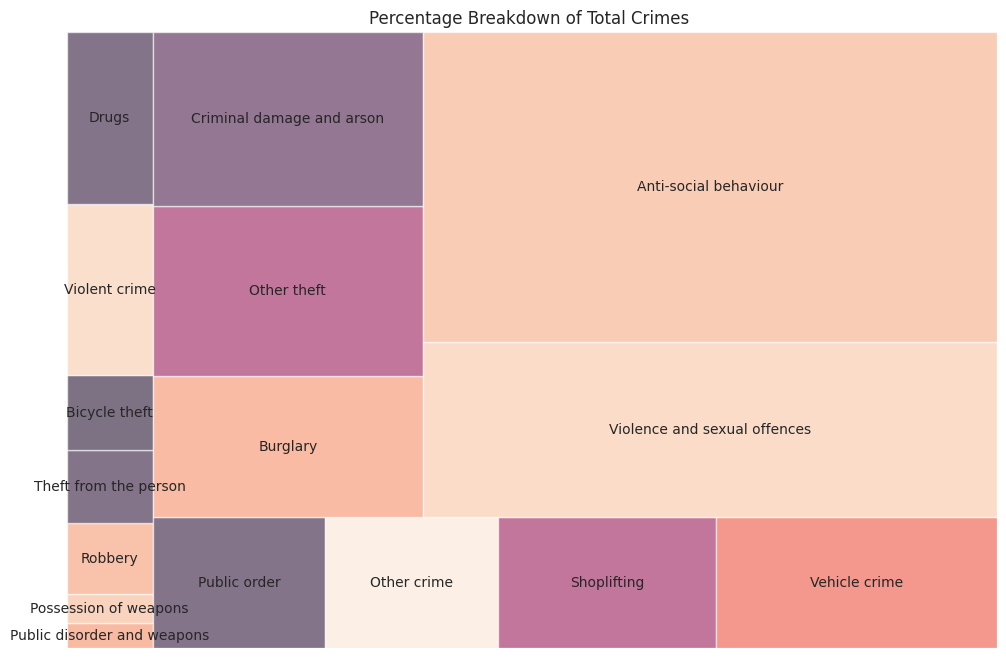

In [ ]:
crimtypy = types_crime.toPandas()
# Treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=crimtypy['cnt'], label=crimtypy['Crime type'], alpha=0.6 )
plt.title('Percentage Breakdown of Total Crimes ')
plt.axis('off')
plt.show()

In [ ]:
viol = violent_crimes
# Assuming 'viol' is your Spark DataFrame
viol_pandas = viol.toPandas()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(viol_pandas['cnt'], labels=viol_pandas['Crime type'], autopct='%1.1f%%', startangle=90)
plt.title('Percentage Breakdown of Violent Crimes')
plt.axis('equal')
plt.show()

NameError: name 'violent_crimes' is not defined

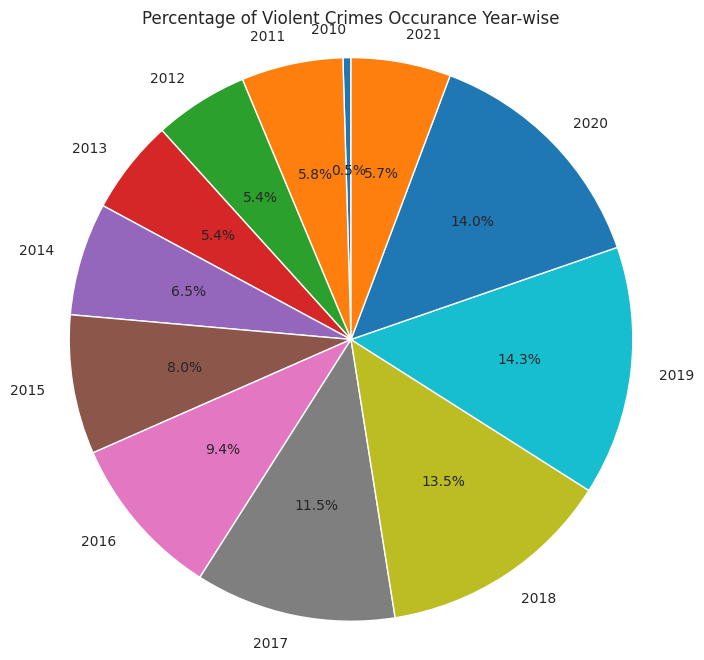

In [ ]:
# copying the dataframe to create new dataframe then adding a column of date type which contains only year
PdTimeseriesdf1 = PdTimeseriesdf.copy()
PdTimeseriesdf1['Year'] = pd.to_datetime(PdTimeseriesdf.index.to_series()).dt.year

# Group by year and sum the crime counts
yearly_crime = PdTimeseriesdf1.groupby('Year')['Crime Count'].sum().reset_index()

#pie chaet
plt.figure(figsize=(8, 8))
plt.pie(yearly_crime['Crime Count'], labels=yearly_crime['Year'], autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Violent Crimes Occurance Year-wise')
plt.axis('equal')
plt.show()

# 5) Selection, application, and reasoning behind use of statistical analysis and multiple evaluation measures   _markdown_, _code_,  _markdown_, 20 Marks

Q3. Determine whether Violent Crimes are increasing, decreasing, or are stable.

Plotting Total Violent Crime Month Wise and Year wise to Visually see changes over time.

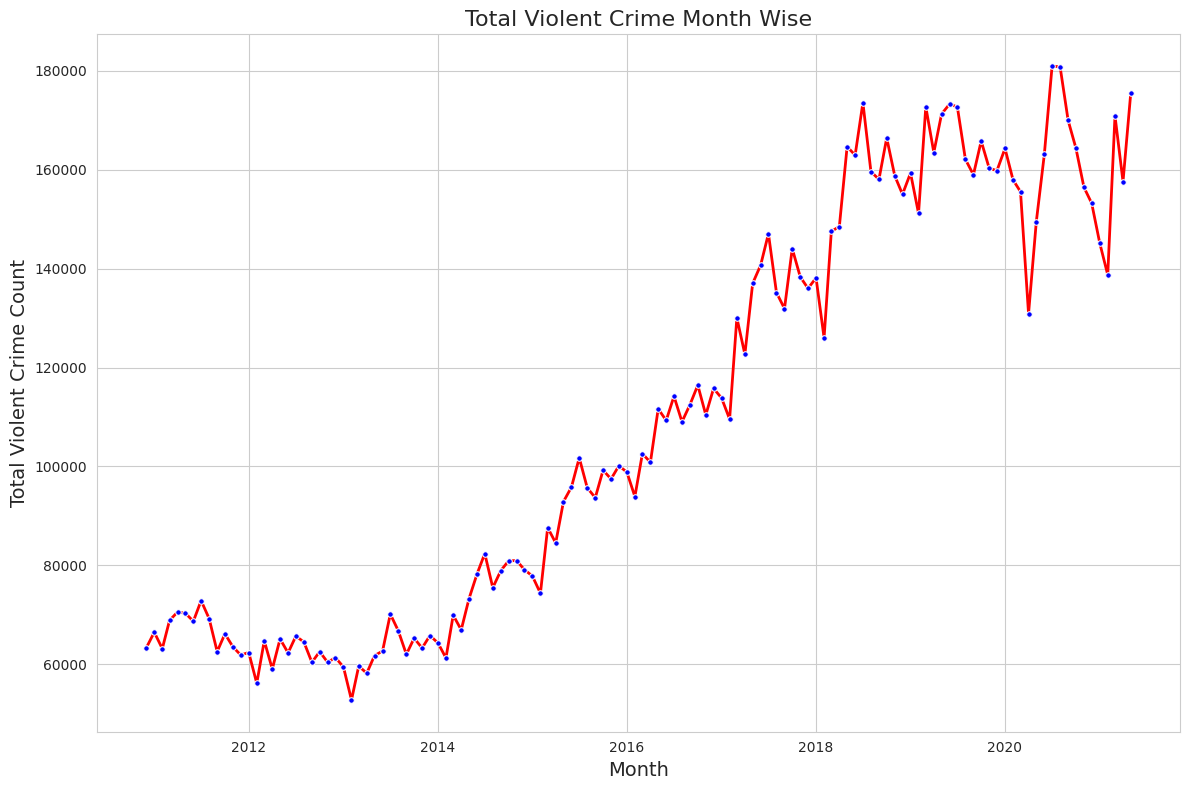

In [ ]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
# Drawing a  lineplot
sns.lineplot(y='Crime Count', x='Month', data=PdTimeseriesdf,
             marker='o', linestyle='-', linewidth=2,
             color='red', markersize=4,markerfacecolor = "blue"
             )

plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Violent Crime Count', fontsize=14)
plt.title('Total Violent Crime Month Wise', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# copying the dataframe to create new dataframe then adding a column of date type which contains only year
PdTimeseriesdf1 = PdTimeseriesdf.copy()
PdTimeseriesdf1['Year'] = pd.to_datetime(PdTimeseriesdf.index.to_series()).dt.year

# Group by year and sum the crime counts
yearly_crime = PdTimeseriesdf1.groupby('Year')['Crime Count'].sum().reset_index()

In [ ]:
yearly_crime

,Year,Crime Count
0,2010,63311
1,2011,804455
2,2012,744774
3,2013,747881
4,2014,891937
5,2015,1101115
6,2016,1295603
7,2017,1586432
8,2018,1859257
9,2019,1970950


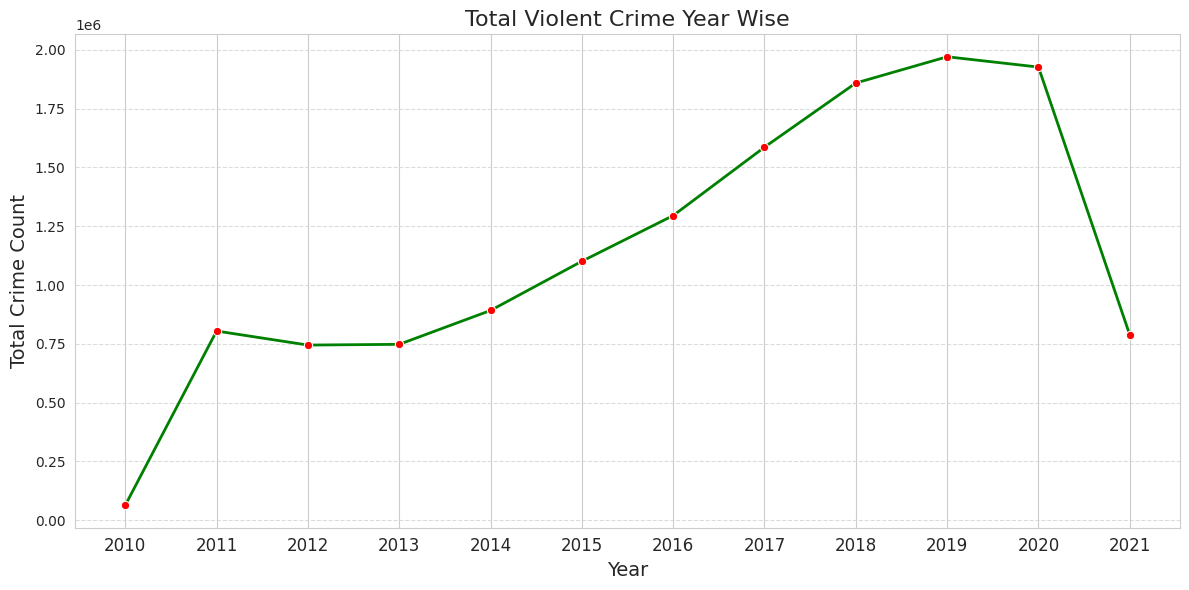

In [ ]:
# Create the line plot as per year
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Crime Count', data=yearly_crime, marker='o', linestyle='-', linewidth=2, color='green', markerfacecolor='Red')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Crime Count', fontsize=14)
plt.title('Total Violent Crime Year Wise', fontsize=16)
plt.xticks(yearly_crime['Year'].unique(), fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Visualizing data distribution in terms of Individual crimes total counts, which belongs to violent crime , over Months and Years

In [ ]:
monthly_crime_counts = timeseries_df.groupBy("Month", "Crime type").agg(F.count("Crime type").alias("Crime Count")).toPandas()
monthly_crime_counts

,Month,Crime type,Crime Count
0,2011-07-01,Violent crime,66572
1,2016-06-01,Robbery,4389
2,2020-10-01,Violence and sexual offences,158725
3,2014-11-01,Robbery,4625
4,2019-12-01,Violence and sexual offences,152970
...,...,...,...
247,2012-05-01,Violent crime,59541
248,2020-05-01,Robbery,3671
249,2011-08-01,Violent crime,63284
250,2012-01-01,Robbery,6066


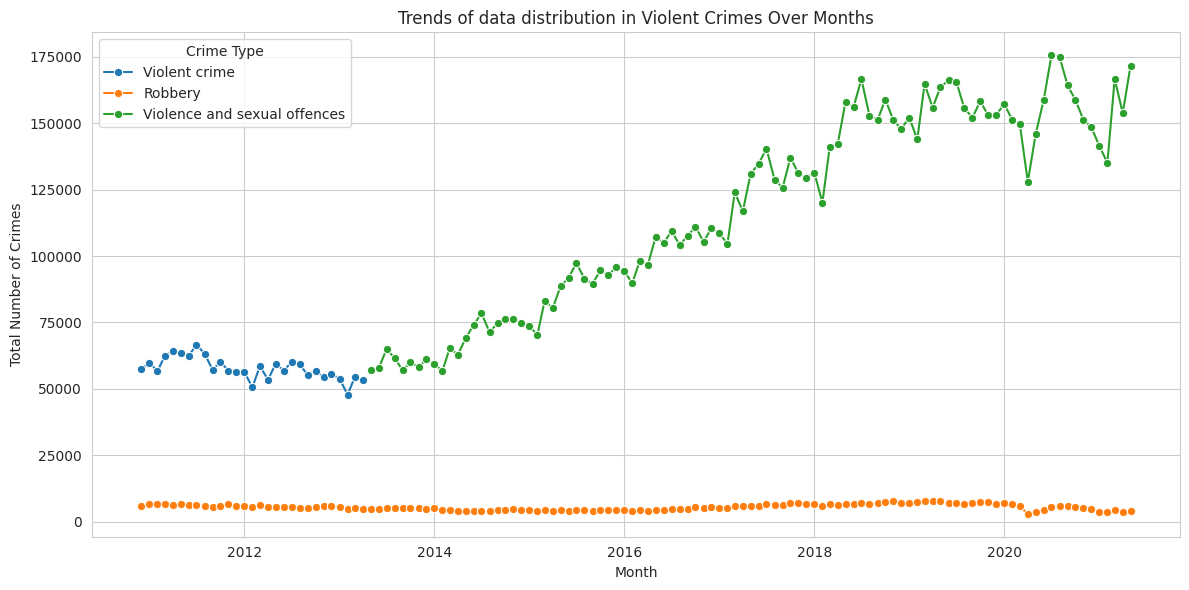

In [ ]:
# Convert 'Month' column to datetime objects
monthly_crime_counts.Month = monthly_crime_counts.Month.astype('datetime64[ns]')

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x="Month", y="Crime Count", hue="Crime type", data=monthly_crime_counts, marker="o")
plt.title("Trends of data distribution in Violent Crimes Over Months")
plt.xlabel("Month")
plt.ylabel("Total Number of Crimes")
plt.legend(title="Crime Type")
plt.tight_layout()
plt.grid(True)
plt.show()


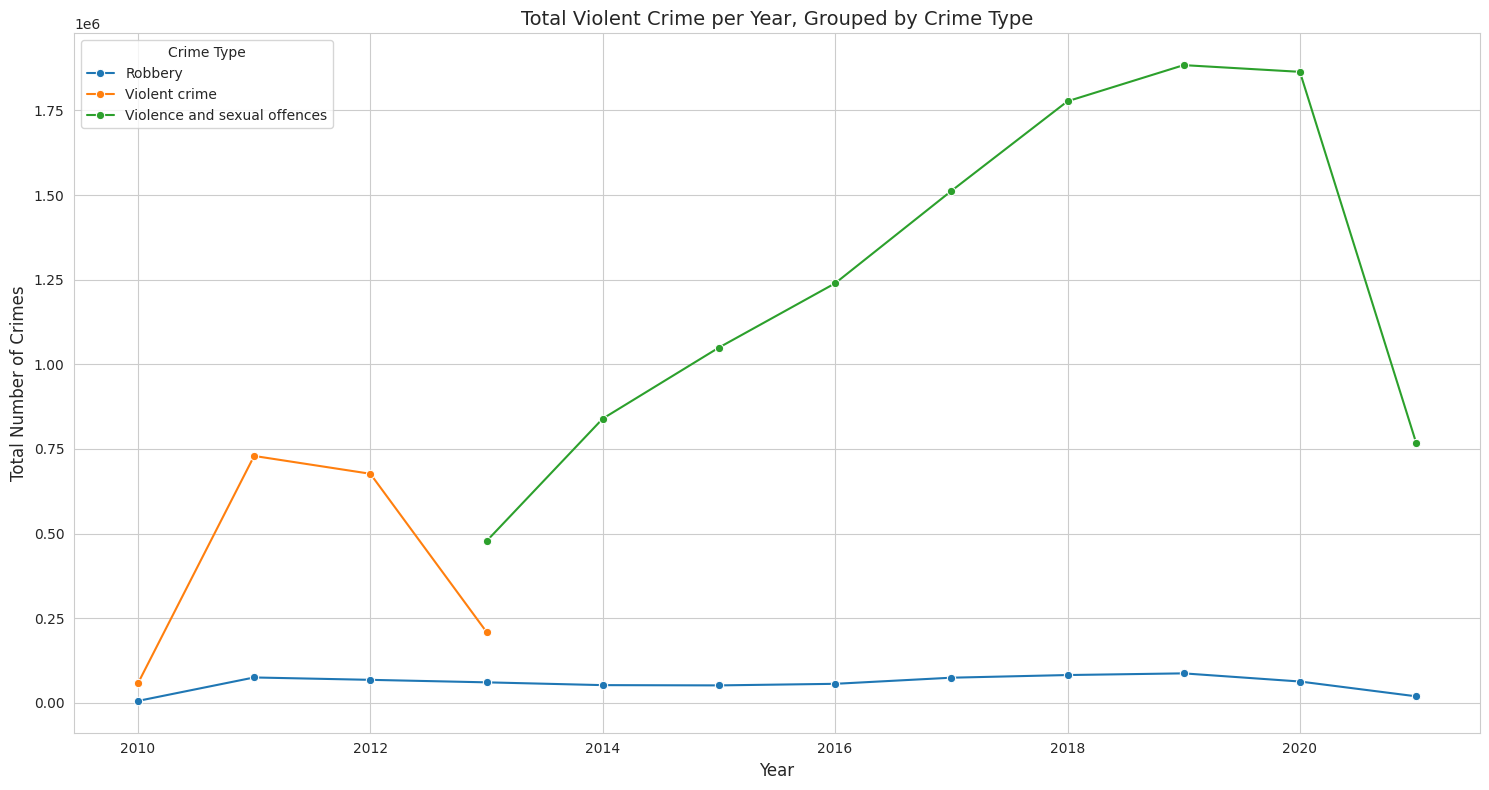

In [ ]:
# Adding a year column with datetimetime derived from month
monthly_crime_counts['Year'] = pd.to_datetime(monthly_crime_counts['Month']).dt.year
# Group by year and crime type, then calculating total crime counts over year
yearly_crime_counts = monthly_crime_counts.groupby(['Year', 'Crime type'])['Crime Count'].sum().reset_index()

# Plotting
plt.figure(figsize=(15, 8))
sns.lineplot(x='Year', y='Crime Count', hue='Crime type', data=yearly_crime_counts, marker='o')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Number of Crimes', fontsize=12)
plt.title('Total Violent Crime per Year, Grouped by Crime Type', fontsize=14)
plt.legend(title='Crime Type')
plt.grid(True)
plt.tight_layout()
plt.show()

Decomoposition Time Series

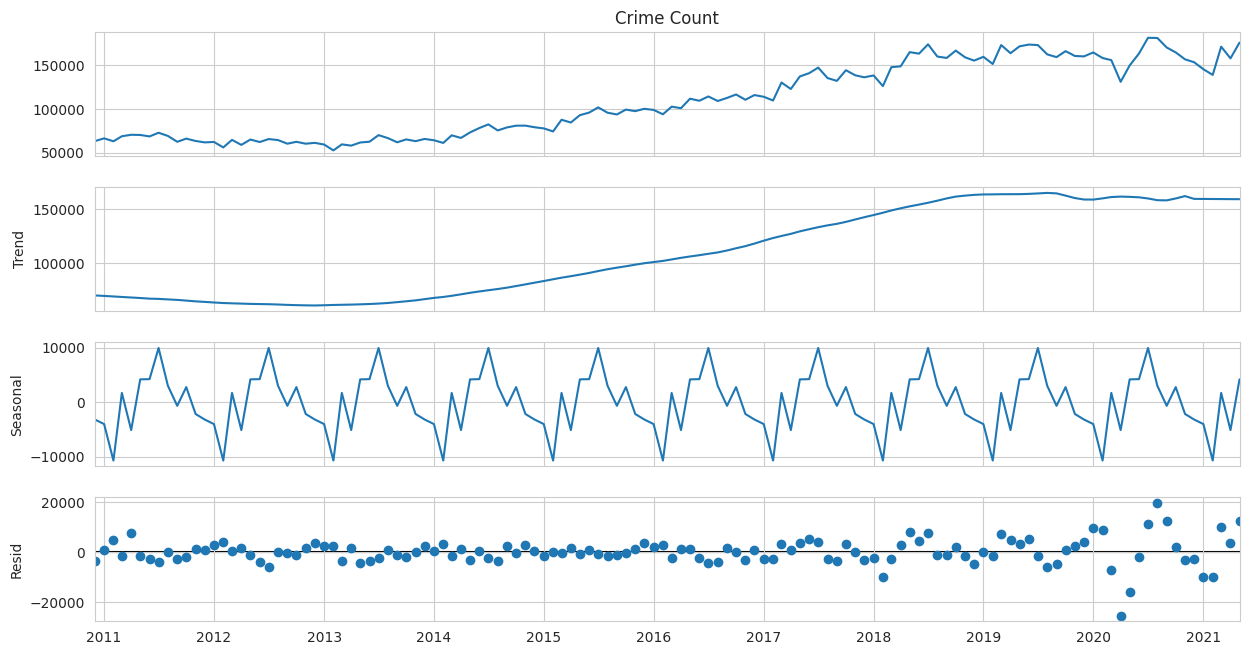

In [ ]:
date_range = pd.date_range(start=PdTimeseriesdfIndex.index.min(), end=PdTimeseriesdfIndex.index.max(), freq='MS')

# Reindex your DataFrame with the new DatetimeIndex, filling missing values with 0
PdTimeseriesdfIndex = PdTimeseriesdfIndex.reindex(date_range, fill_value=0)


decomposition = sm.tsa.seasonal_decompose(PdTimeseriesdfIndex['Crime Count'],
                                          model='additive', extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

Check if Time Series Data is Stationary

1. Using Rolling Mean and Rolling Variance Method Visual Analysis

In [ ]:
# Calculate rolling mean and variance
rolling_mean = PdTimeseriesdf['Crime Count'].rolling(window=12).mean()
rolling_variance = PdTimeseriesdf['Crime Count'].rolling(window=12).var()

# Create a new DataFrame to store results
result_df = pd.DataFrame({'Rolling Mean': rolling_mean, 'Rolling Variance': rolling_variance}).dropna()

result_df

,Rolling Mean,Rolling Variance
Month,,
2011-11-01,67156.333333,1.188468e+07
2011-12-01,67037.916667,1.304644e+07
2012-01-01,66696.250000,1.485572e+07
2012-02-01,66112.666667,2.343116e+07
2012-03-01,65769.000000,2.277045e+07
...,...,...
2021-01-01,158998.583333,2.043107e+08
2021-02-01,157396.583333,2.387412e+08
2021-03-01,158675.833333,2.532361e+08


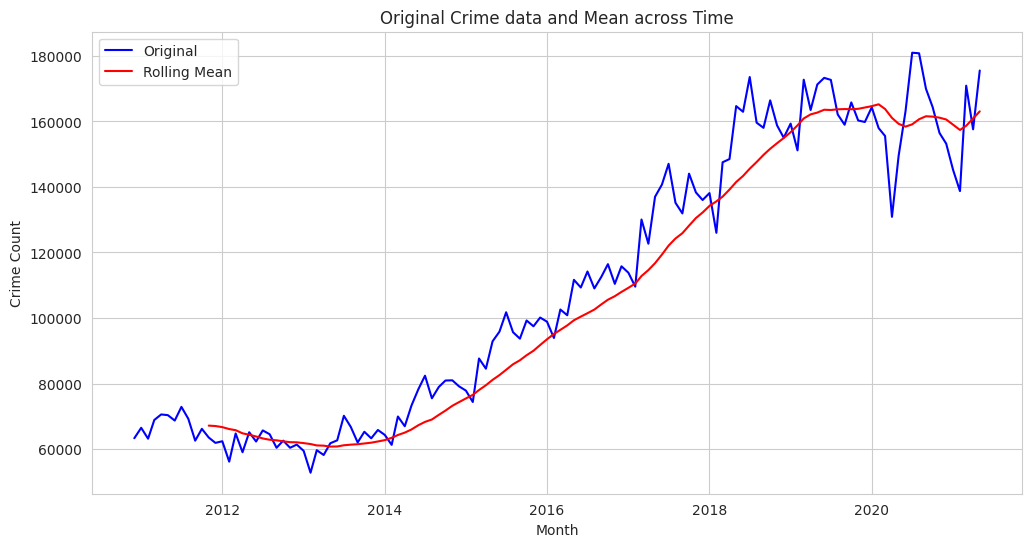

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(PdTimeseriesdf['Crime Count'], label='Original', color='blue')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.legend(loc='best')
plt.title('Original Crime data and Mean across Time')
plt.xlabel('Month')
plt.ylabel('Crime Count')
plt.show()


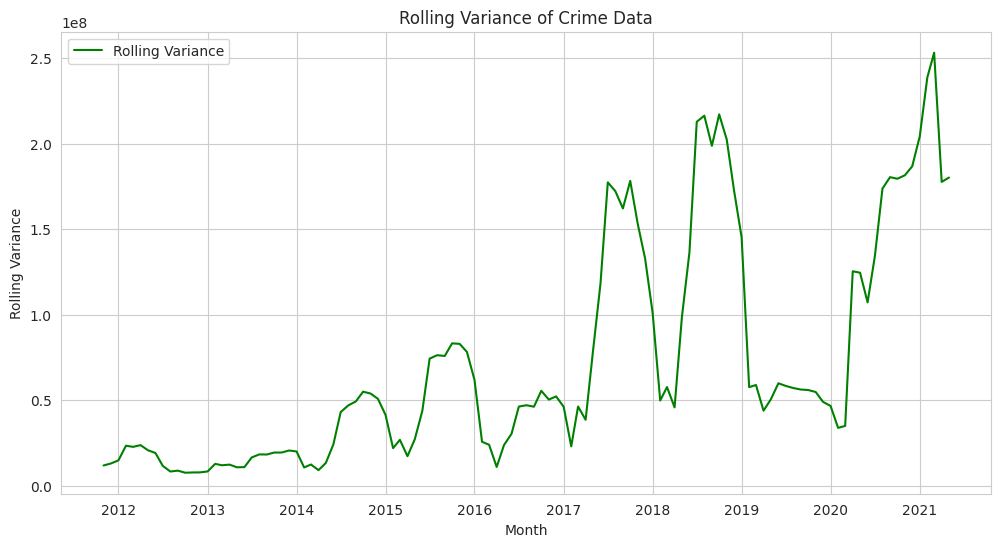

In [ ]:
# Plot rolling variance separately
plt.figure(figsize=(12, 6))
plt.plot(rolling_variance, label='Rolling Variance', color='green')
plt.legend(loc='best')
plt.title('Rolling Variance of Crime Data')
plt.xlabel('Month')
plt.ylabel('Rolling Variance')
plt.show()


2. Using Autocorrelation Function Plot (ACF)

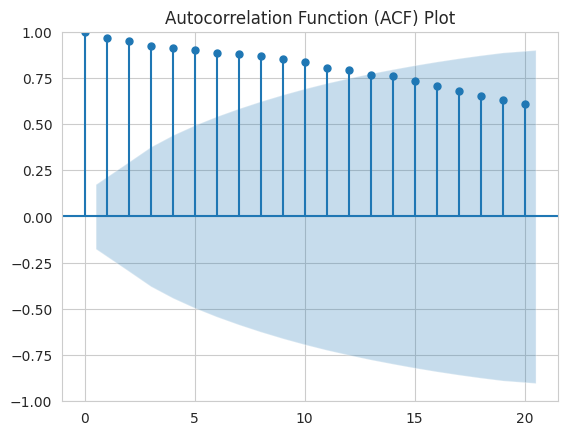

In [ ]:
plot_acf(PdTimeseriesdf['Crime Count'], lags=20)
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()


3. Using Augmented Dickey Fuller Test(ADF)

In [ ]:
def ADF_test(timeseries, dataDesc):
  print(' > Is the {} stationary ?'.format(dataDesc))
  dftest = adfuller(timeseries.dropna(), autolag='AIC')
  print('Test statistic = {:.3f}'.format(dftest[0]))
  print('P-value = {:.3f}'.format(dftest[1]))
  print('Critical values :')
  for k, v in dftest[4].items():
    print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [ ]:
ADF_test(PdTimeseriesdf['Crime Count'], ' Original Crime Data')

 > Is the  Original Crime Data stationary ?
Test statistic = -0.417
P-value = 0.907
Critical values :
	1%: -3.4901313156261384 - The data is not stationary with 99% confidence
	5%: -2.8877122815688776 - The data is not stationary with 95% confidence
	10%: -2.5807296460459184 - The data is not stationary with 90% confidence


Detrending Data

In [ ]:
CrimeData_detrend = (PdTimeseriesdf - PdTimeseriesdf.rolling(window=12).mean())/PdTimeseriesdf.rolling(window=12).std()
CrimeData_detrend.dropna(inplace=True)
ADF_test(CrimeData_detrend,'Detrended Crime Data')

 > Is the Detrended Crime Data stationary ?
Test statistic = -1.442
P-value = 0.562
Critical values :
	1%: -3.4968181663902103 - The data is not stationary with 99% confidence
	5%: -2.8906107514600103 - The data is not stationary with 95% confidence
	10%: -2.5822770483285953 - The data is not stationary with 90% confidence


Using Differencing Method

In [ ]:
CrimeData_diff = PdTimeseriesdf - PdTimeseriesdf.shift(12)
CrimeData_diff.dropna(inplace=True)
ADF_test(CrimeData_diff,'Differenced Crime Data')

 > Is the Differenced Crime Data stationary ?
Test statistic = -1.938
P-value = 0.314
Critical values :
	1%: -3.4968181663902103 - The data is not stationary with 99% confidence
	5%: -2.8906107514600103 - The data is not stationary with 95% confidence
	10%: -2.5822770483285953 - The data is not stationary with 90% confidence


Using Detrending and Differencing Together

In [ ]:
Crime_Data_detrend_diff = CrimeData_detrend - CrimeData_detrend.shift(12)
Crime_Data_detrend_diff.dropna(inplace=True)
ADF_test(Crime_Data_detrend_diff,'Detrended and Differenced Crime Data')

 > Is the Detrended and Differenced Crime Data stationary ?
Test statistic = -2.209
P-value = 0.203
Critical values :
	1%: -3.505190196159122 - The data is not stationary with 99% confidence
	5%: -2.894232085048011 - The data is not stationary with 95% confidence
	10%: -2.5842101234567902 - The data is not stationary with 90% confidence


Using Log Transform

In [ ]:
CrimeData_log = np.log(PdTimeseriesdf)
CrimeData_log.dropna(inplace=True)
ADF_test(CrimeData_log,'Log Transformed Crime Data')

 > Is the Log Transformed Crime Data stationary ?
Test statistic = -0.751
P-value = 0.833
Critical values :
	1%: -3.489589552580676 - The data is not stationary with 99% confidence
	5%: -2.887477210140433 - The data is not stationary with 95% confidence
	10%: -2.580604145195395 - The data is not stationary with 90% confidence


Use Sliding window to get how many points to be shifted in Detrending and Differencing Together to obtain stationary data

In [ ]:
def ADF_auto(timeseries):
    test = adfuller(timeseries.dropna(), autolag='AIC')
    for k, v in test[4].items():
        if v < test[0] : return 0
        else: return 1

def rollWin_lag_val(timeseries):
    pv = []
    for lag in range(1, 100):
        s = timeseries - timeseries.shift(int(lag))
        if ADF_auto(s) == 0:
            continue
        else:
            pv.append(lag)
    print(" Possible rolling window lag values are: ", pv)


rollWin_lag_val(Crime_Data_detrend_diff)

 Possible rolling window lag values are:  [3, 13, 24, 30, 87]


In [ ]:
Crime_Data_detrend_diff = CrimeData_detrend - CrimeData_detrend.shift(3)
Crime_Data_detrend_diff.dropna(inplace=True)
ADF_test(Crime_Data_detrend_diff,'Detrended and Differenced Crime Data')

 > Is the Detrended and Differenced Crime Data stationary ?
Test statistic = -2.915
P-value = 0.044
Critical values :
	1%: -3.497501033 - The data is not stationary with 99% confidence
	5%: -2.89090644 - The data is  stationary with 95% confidence
	10%: -2.5824349 - The data is  stationary with 90% confidence


In [ ]:
Crime_Data_detrend_diff

,Crime Count
Month,
2012-02-01,-1.000510
2012-03-01,1.213783
2012-04-01,-0.065370
2012-05-01,2.221931
2012-06-01,-0.137389
...,...
2021-01-01,-1.182722
2021-02-01,-0.860283
2021-03-01,1.307805


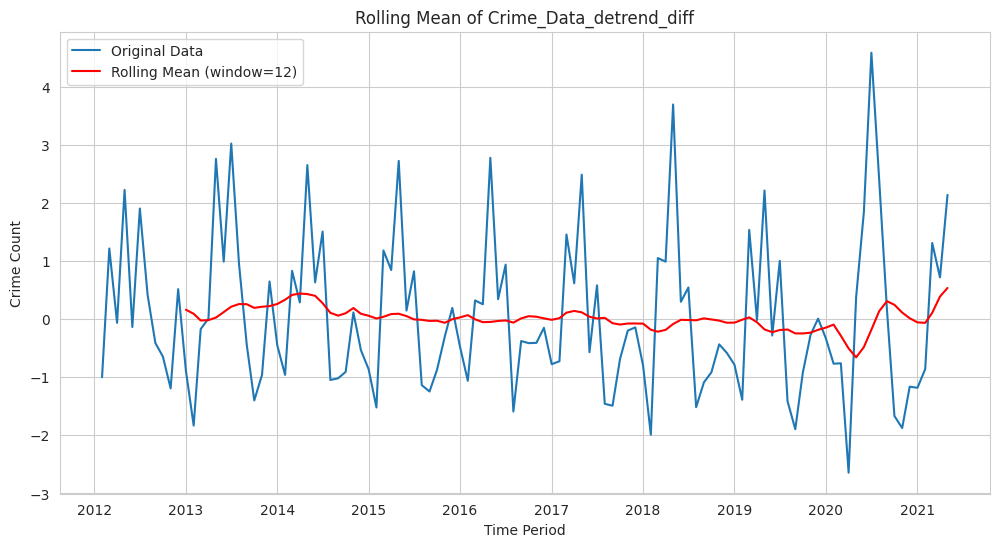

In [ ]:
# Calculate the rolling mean
rolling_mean = Crime_Data_detrend_diff.rolling(window=12).mean()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(Crime_Data_detrend_diff, label='Original Data')
plt.plot(rolling_mean, label='Rolling Mean (window=12)', color='red')
plt.legend()
plt.title('Rolling Mean of Crime_Data_detrend_diff')
plt.xlabel('Time Period')  # Replace with appropriate x-axis label
plt.ylabel('Crime Count') # Replace with appropriate y-axis label
plt.show()

Model

In [ ]:
# Splitting data as training and testing data
Crime_Predict = Crime_Data_detrend_diff
y_train = Crime_Data_detrend_diff[:'2018-12-01']
y_test = Crime_Data_detrend_diff['2019-12-01':]

In [ ]:
import itertools

# Define ranges for p, q, r
p = q = r = range(0, 2)
seasonal_period = 12

# Generate all combinations of p, q, r
pqr = list(itertools.product(p, q, r))

# Generate seasonal parameters
seasonal_pqr = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, q, r))]

# Print results
print("Non-seasonal parameters (p, q, r):", pqr)
print("Seasonal parameters (P, Q, R, s):", seasonal_pqr)


Non-seasonal parameters (p, q, r): [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
Seasonal parameters (P, Q, R, s): [(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [ ]:
import warnings
warnings.filterwarnings("ignore")
best_aic = np.inf
best_model = None
best_param = None
best_param_seasonal = None

for param in pqr:
    for param_seasonal in seasonal_pqr:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_model = results
                best_param = param
                best_param_seasonal = param_seasonal
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as ex:
            print(f"Error with ARIMA{param}x{param_seasonal}12: {ex}")
            continue

print(f"\nBest model: ARIMA{best_param}x{best_param_seasonal}")
print(f"Best AIC: {best_aic}")

# Make predictions with the best model
forecast_steps = 12  # Adjust as needed
forecast = best_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

print("\nForecast:")
print(forecast_mean)
print("\nConfidence Intervals:")
print(forecast_ci)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:271.9902076092419
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:226.06843312769084
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:146.30664429414287
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:134.93814179002734
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:182.93317204968525
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:174.28080636309946
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:134.4944169157617
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:135.8746784475938
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:270.692525206727
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:223.8071951649381
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:132.63720984330376
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:121.22794182211227
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:172.3210942783768
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:162.4069579566782
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:122.27007476177884
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:122.8413031732933
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:302.48446688051365
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:256.1993173321192
AR

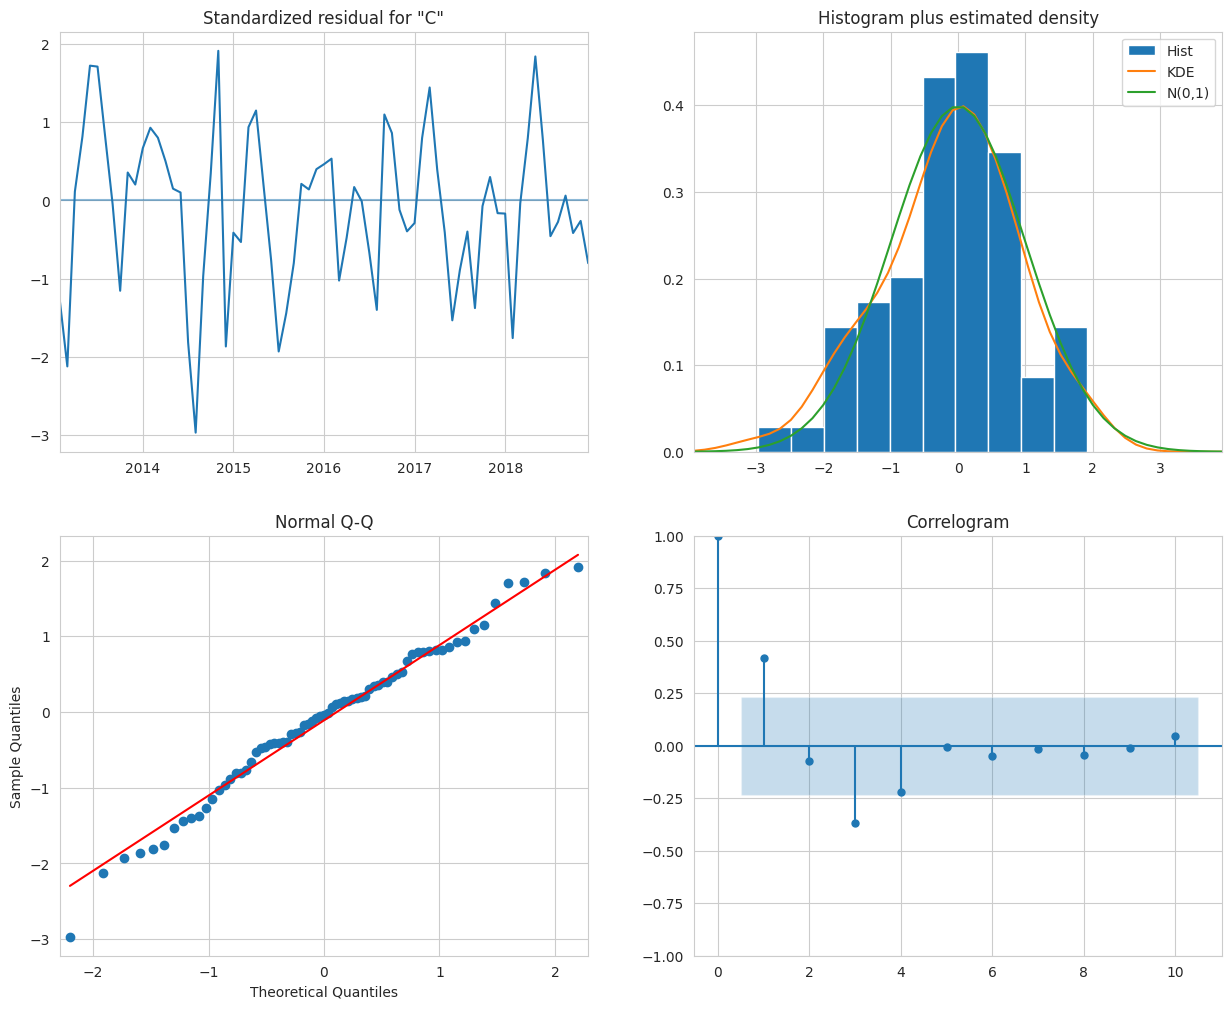

In [ ]:
best_model = sm.tsa.statespace.SARIMAX(y_train, order=(0, 0, 0),
                                       seasonal_order=(0, 1, 1, 12), enforce_invertibility=False).fit()
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()


Q4. Determine whether there are more firearms incidents per head in Liverpool than anywhere else in the UK

In [ ]:
# Merge the two dataframes based on location name
firearm_merged_df = pd.merge(firearm_crime_counts_by_location, location_df, left_index=True, right_index=True, how='left')

# Rename columns for clarity
firearm_merged_df = firearm_merged_df.rename(columns={'Firearm Incidents': 'Firearm Incidents Count',
                                      'Variable: All usual residents; measures: Value': 'Population'})

# Calculate firearm incidents per capita
firearm_merged_df['Incidents Per Capita'] = firearm_merged_df['Firearm Incidents Count'] / firearm_merged_df['Population']

# Sort by incidents per capita in descending order
firearm_merged_df = firearm_merged_df.sort_values('Incidents Per Capita', ascending=False)

# Display the result
firearm_merged_df

,Firearm Incidents Count,Population,Incidents Per Capita
LSOA name,,,
City of London,17,7375,0.002305
Westminster,129,219396,0.000588
Derby,130,248752,0.000523
Norwich,66,132512,0.000498
Nottingham,148,305680,0.000484
...,...,...,...
Runnymede,1,80510,0.000012
Harborough,1,85382,0.000012
North West Leicestershire,1,93468,0.000011


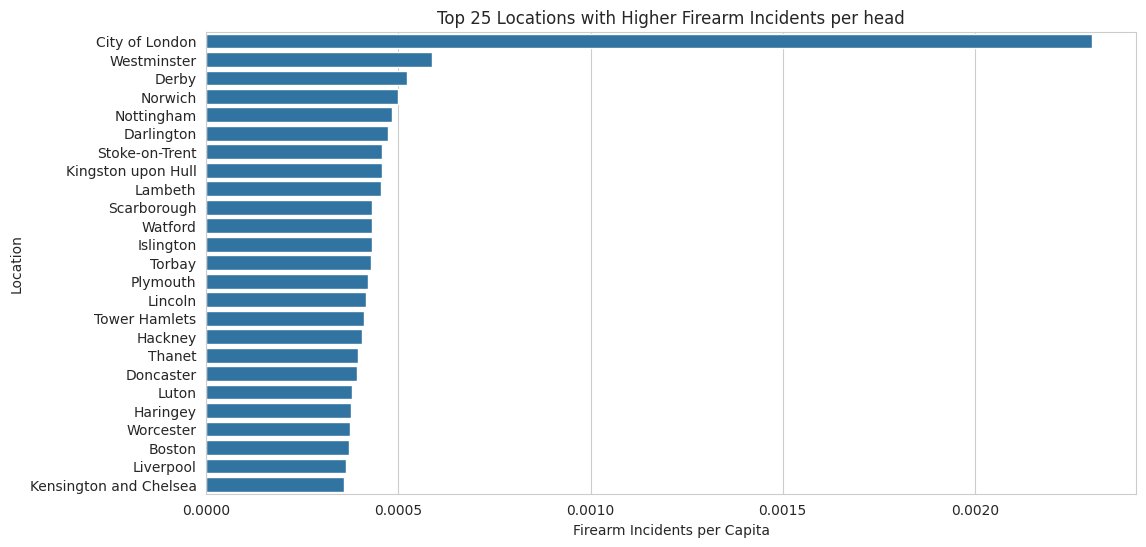

Firearm incidents per capita in Liverpool: 0.00036448227436939207
Liverpool does not have the highest firearm incidents per capita.


In [ ]:
top_25_loc = firearm_merged_df.head(25)

# plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Incidents Per Capita', y=top_25_loc.index, data=top_25_loc)
plt.xlabel('Firearm Incidents per Capita')
plt.ylabel('Location')
plt.title('Top 25 Locations with Higher Firearm Incidents per head')
plt.show()

# Checking for hiighest crime rate
liverpool_rate = firearm_merged_df.loc['Liverpool', 'Incidents Per Capita'] if 'Liverpool' in firearm_merged_df.index else None
if liverpool_rate is not None:
  print(f"Firearm incidents per capita in Liverpool: {liverpool_rate}")
  if firearm_merged_df['Incidents Per Capita'].max() == liverpool_rate:
    print("Liverpool has the highest firearm incidents per capita among the top locations")
  else:
      print("Liverpool does not have the highest firearm incidents per capita.")
else:
  print("Data for Liverpool not found.")

Q5. Determining whether firearms incidents are associated with drugs offences

In [ ]:
firearm_crime_counts_by_location = firearm_crime_counts_by_location.reset_index()
drug_crime_counts_by_location = drug_crime_counts_by_location.reset_index()

# Now, join the firearm incidents and drug offenses dataframes based on LSOA name
joined_df1 = firearm_crime_counts_by_location.merge(drug_crime_counts_by_location, on="LSOA name", how="left") # Use merge here.

# Fill NaN values in 'Drug Offenses' column with 0
joined_df1 = joined_df1.fillna(0)

# Show the joined DataFrame
joined_df1.head() # Use head() to display the first few rows in the notebook instead of show()

# Calculate the correlation between firearm incidents and drug offenses
correlation = joined_df1['Firearm Incidents'].corr(joined_df1['Drug Offenses'])

print(f"Correlation between firearm incidents and drug offenses: {correlation}")
joined_df1

Correlation between firearm incidents and drug offenses: 0.8411969373107647


,LSOA name,Firearm Incidents,Drug Offenses
0,Birmingham,235,28306
1,Leeds,203,24357
2,Liverpool,170,47194
3,Manchester,157,16933
4,Sheffield,156,12667
...,...,...,...
332,Runnymede,1,3050
333,Harborough,1,808
334,Lewes,1,1390
335,North West Leicestershire,1,1289


In [ ]:
# Convert 'LSOA name' column in both DataFrames to string type
firearm_incidents_by_lsoa['LSOA name'] = firearm_incidents_by_lsoa['LSOA name'].astype(str)
drug_offenses_by_lsoa['LSOA name'] = drug_offenses_by_lsoa['LSOA name'].astype(str)

# Now, join the firearm incidents and drug offenses dataframes based on LSOA name
joined_df = firearm_incidents_by_lsoa.merge(drug_offenses_by_lsoa, on="LSOA name", how="left") # Use merge here.

# Fill NaN values in 'Drug Offenses' column with 0
joined_df = joined_df.fillna(0)

joined_df
# Show the joined DataFrame
joined_df.head() # Use head() to display the first few rows in the notebook instead of show()

# Calculate the correlation between firearm incidents and drug offenses
correlation = joined_df['Firearm Incidents'].corr(joined_df['Drug Offenses'])

print(f"Correlation between firearm incidents and drug offenses: {correlation}")
joined_df

Correlation between firearm incidents and drug offenses: 0.6390260535309379


,LSOA name,Firearm Incidents,Drug Offenses
0,Sheffield 074C,17,374.0
1,Bradford 039G,17,646.0
2,Liverpool 044D,1,226.0
3,Amber Valley 010C,2,32.0
4,Blackpool 010D,4,465.0
...,...,...,...
6174,Lincoln 006C,1,53.0
6175,Telford and Wrekin 014F,1,38.0
6176,West Berkshire 011D,1,17.0
6177,Westminster 010A,1,68.0


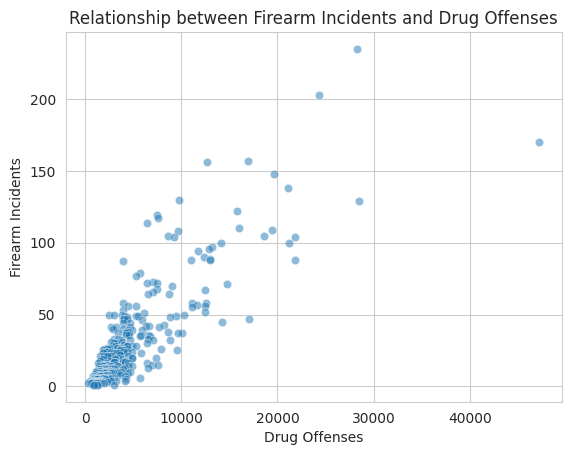

In [ ]:
# Create a scatter plot
sns.scatterplot(x='Drug Offenses', y='Firearm Incidents', data=joined_df1, alpha=0.5)
plt.title('Relationship between Firearm Incidents and Drug Offenses')
plt.xlabel('Drug Offenses')
plt.ylabel('Firearm Incidents')
plt.show()

Pearson Correlation: 0.8411969373107647
Spearman Correlation: 0.8422909884226308


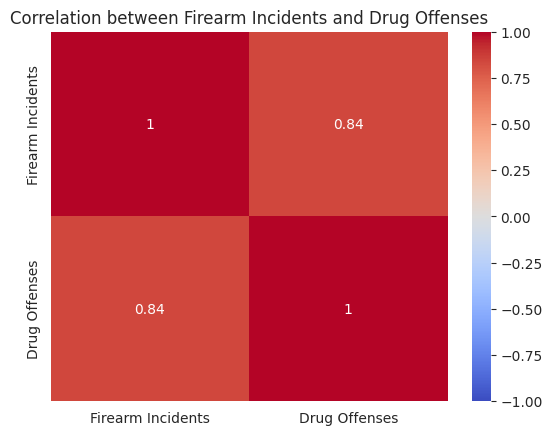

T-statistic: -16.636080303255316
P-value: 2.6652300284036385e-52
There is a statistically significant association between firearm incidents and drug offenses.


In [ ]:
# Calculate Pearson correlation
pearson_corr = joined_df1['Firearm Incidents'].corr(joined_df1['Drug Offenses'], method='pearson')

# Calculate Spearman correlation
spearman_corr = joined_df1['Firearm Incidents'].corr(joined_df1['Drug Offenses'], method='spearman')

# Print the correlation values
print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")

# Create a correlation plot (heatmap)
corr_matrix = joined_df1[['Firearm Incidents', 'Drug Offenses']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Firearm Incidents and Drug Offenses')
plt.show()

# Statistical significance using hypothesis testing (example: t-test)
t_statistic, p_value = stats.ttest_ind(joined_df1['Firearm Incidents'], joined_df1['Drug Offenses'])
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpretation of results
if p_value <= 0.05:
    print("There is a statistically significant association between firearm incidents and drug offenses.")
else:
    print("There is no statistically significant association between firearm incidents and drug offenses.")

                              OLS Regression Results                              
Dep. Variable:     Q("Firearm Incidents")   R-squared:                       0.693
Model:                                OLS   Adj. R-squared:                  0.692
Method:                     Least Squares   F-statistic:                     603.4
Date:                    Mon, 13 Jan 2025   Prob (F-statistic):           1.80e-70
Time:                            20:45:30   Log-Likelihood:                -1176.9
No. Observations:                     269   AIC:                             2358.
Df Residuals:                         267   BIC:                             2365.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

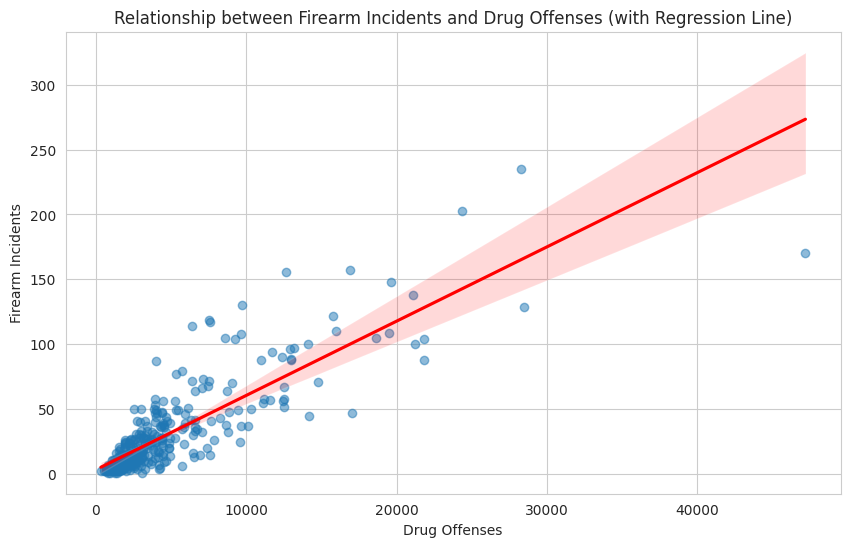

In [ ]:
# 1. Train-Test Split
X = joined_df1[['Drug Offenses']]  # Independent variable
y = joined_df1['Firearm Incidents']  # Dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create training and testing DataFrames
train_df = pd.DataFrame({'Drug Offenses': X_train['Drug Offenses'], 'Firearm Incidents': y_train})
test_df = pd.DataFrame({'Drug Offenses': X_test['Drug Offenses'], 'Firearm Incidents': y_test})

# 2. Linear Regression Model (using statsmodels)
model = smf.ols(formula='Q("Firearm Incidents") ~ Q("Drug Offenses")', data=train_df).fit()

# 3. Predictions
y_pred = model.predict(test_df[['Drug Offenses']])

# 4. Evaluation (example: R-squared)
print(model.summary())  # Print model summary (includes R-squared)

# 5. Visualization
plt.figure(figsize=(10, 6))
sns.regplot(x='Drug Offenses', y='Firearm Incidents', data=joined_df1, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Relationship between Firearm Incidents and Drug Offenses (with Regression Line)')
plt.xlabel('Drug Offenses')
plt.ylabel('Firearm Incidents')
plt.show()

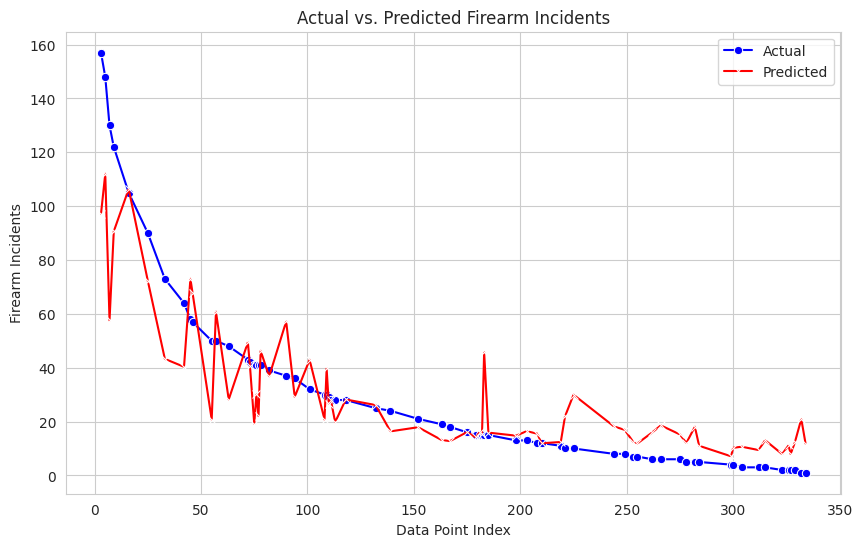

Correlation between Actual and Predicted: 0.8930577666066716


In [ ]:
# Create a DataFrame for plotting
plot_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Line chart with different colors
plt.figure(figsize=(10, 6))
sns.lineplot(x=plot_df.index, y='Actual', data=plot_df, label='Actual', color='blue', marker='o')
sns.lineplot(x=plot_df.index, y='Predicted', data=plot_df, label='Predicted', color='red', marker='x')

plt.title('Actual vs. Predicted Firearm Incidents')
plt.xlabel('Data Point Index')
plt.ylabel('Firearm Incidents')
plt.legend()
plt.grid(True)
plt.show()

# Calculate  correlation
correlation = plot_df['Actual'].corr(plot_df['Predicted'])
print(f"Correlation between Actual and Predicted: {correlation}")

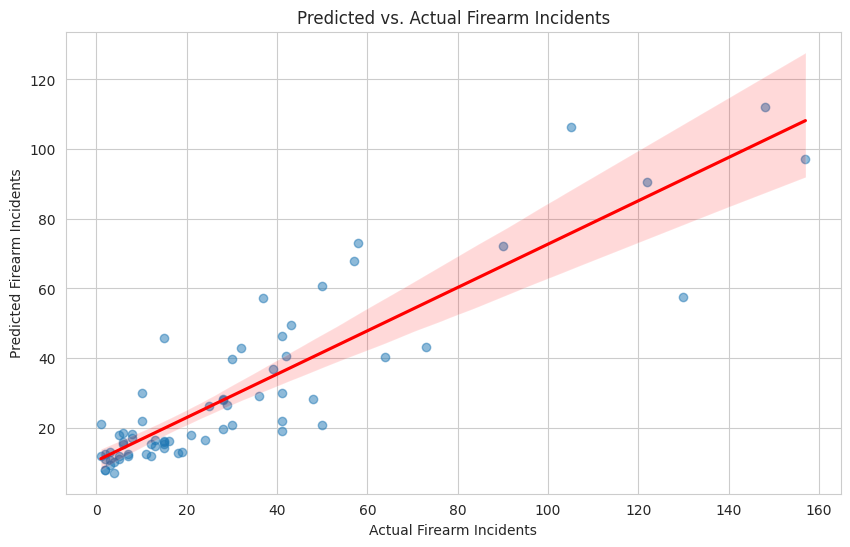

In [ ]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.regplot(x='Actual', y='Predicted', data=plot_df, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Predicted vs. Actual Firearm Incidents')
plt.xlabel('Actual Firearm Incidents')
plt.ylabel('Predicted Firearm Incidents')
plt.grid(True)
plt.show()

In [ ]:
compare_predictions = pd.DataFrame({'Predicted': y_pred, 'Actual': y_test.values})

In [ ]:
compare_predictions

,Predicted,Actual
46,67.848230,57
163,13.148425,19
57,60.806302,50
25,72.255609,90
113,19.767727,28
...,...,...
255,11.864083,7
7,57.562515,130
327,7.895795,2
90,57.205753,37


**References**


